# Generative Adversarial Networks (GANs)

In this lab, we are going to implement a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

In [ ]:
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [2]:
latent_dims = 10
num_epochs = 20
batch_size = 128
learning_rate = 2e-4
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We scale to 64x64 so we can have a deeper architecture with more down-sampling steps. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [10]:
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.03MB/s]


GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters. Kernel size 4 is used to avoid biasing problems.

### **Generator**

In [4]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

### **Discriminator**

In [7]:
class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

In [ ]:
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12656257 and discriminator: 11033985


Train GAN
--------


GAN training can be unstable. In this case, the strong momentum for the gradient prevents convergence. One possible explanation is that the strong momentum does not allow the two players in the adversarial game to react to each other quickly enough.

Decreasing beta1 (the exponential decay for the gradient moving average in [0,1], lower is faster decay) from the default 0.9 to 0.5 allows for quicker reactions.

In [ ]:
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training ...
Epoch [1 / 20] average loss generator vs. discrim.: 5.170267 vs. 20.801477
Epoch [2 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [3 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [4 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [5 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [6 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [7 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [8 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [9 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [10 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [11 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [12 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [13 / 20] average loss generator vs. discrim.: 0.000000 vs. 50.000000
Epoch [1

Plot Training Curves
--------------------

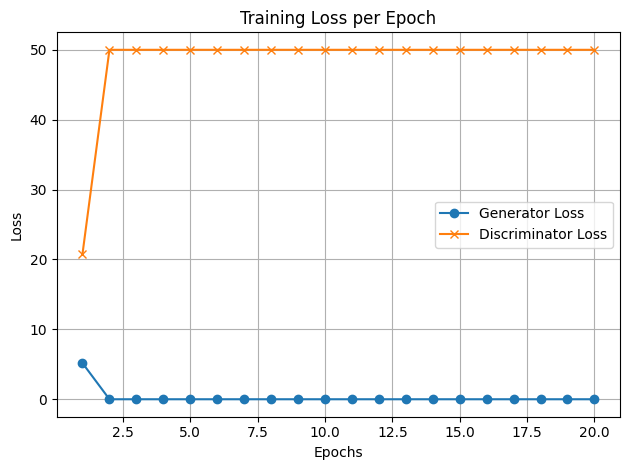

In [16]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

Training ...
Epoch [1/20] Generator Loss: 3.2903, Discriminator Loss: 0.3792


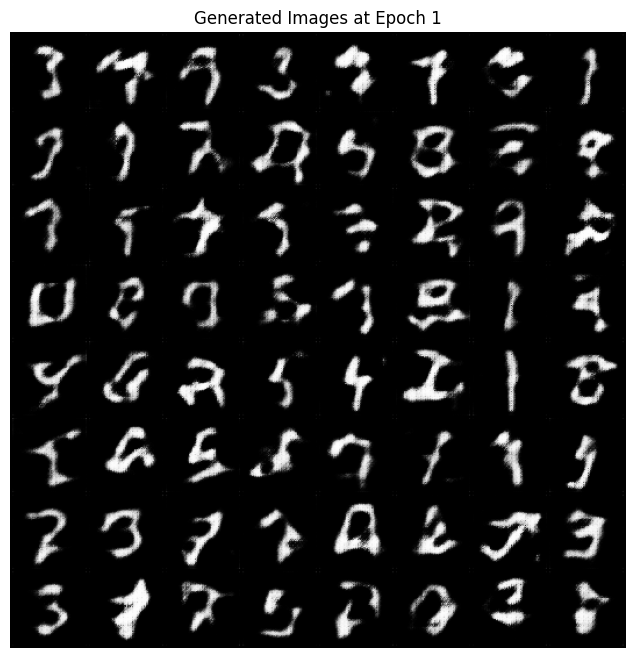

Epoch [2/20] Generator Loss: 2.1823, Discriminator Loss: 0.3972


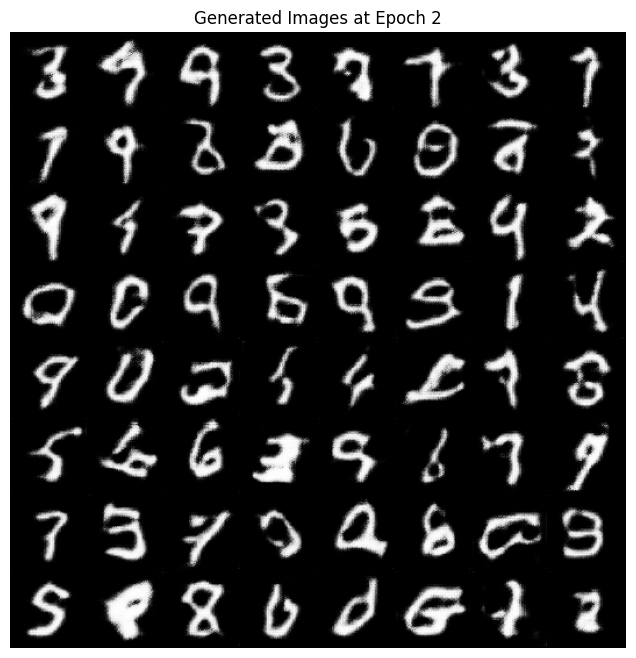

Epoch [3/20] Generator Loss: 2.8165, Discriminator Loss: 0.3142


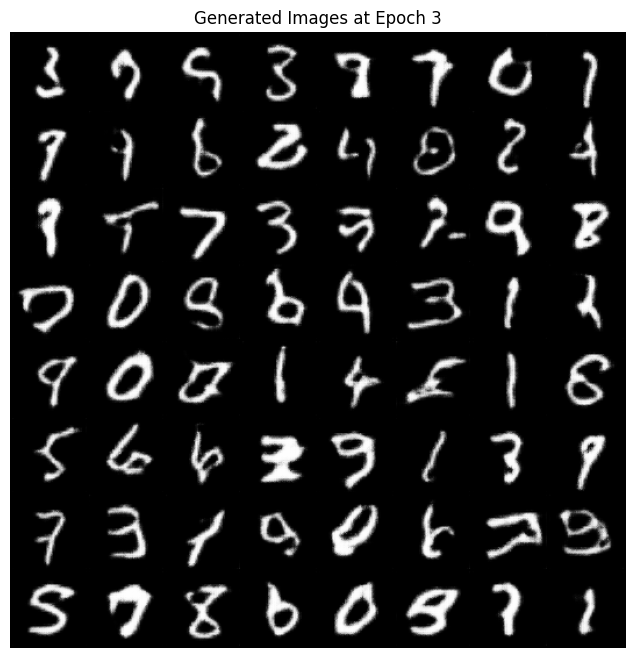

Epoch [4/20] Generator Loss: 3.0464, Discriminator Loss: 0.3111


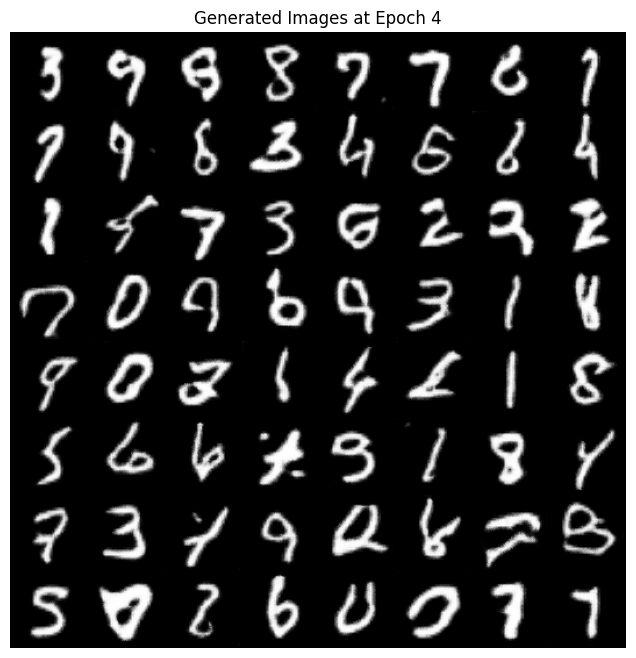

Epoch [5/20] Generator Loss: 3.1558, Discriminator Loss: 0.2975


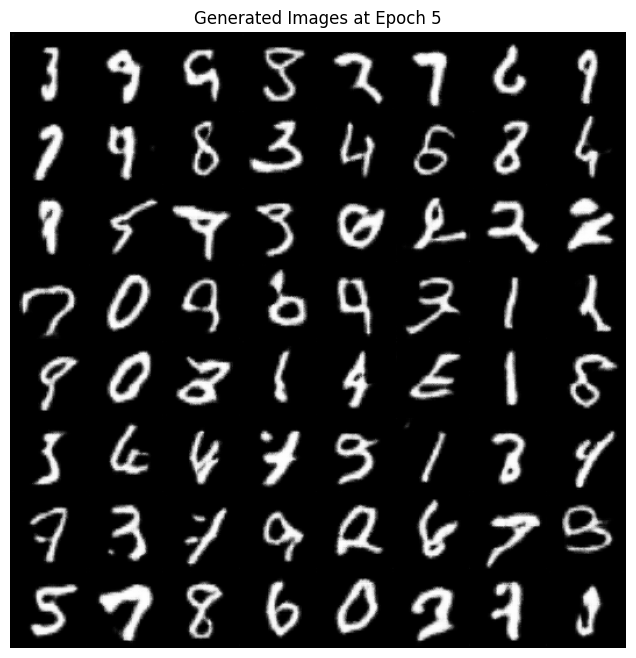

Epoch [6/20] Generator Loss: 3.7263, Discriminator Loss: 0.2127


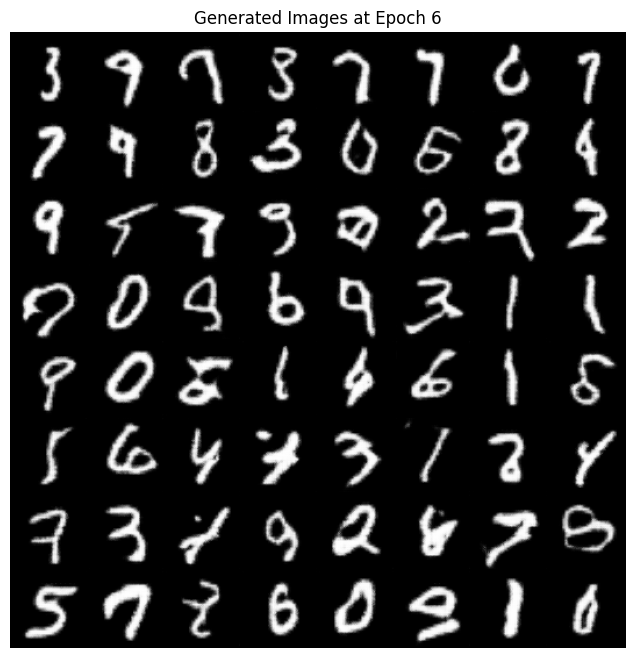

Epoch [7/20] Generator Loss: 3.1384, Discriminator Loss: 0.3378


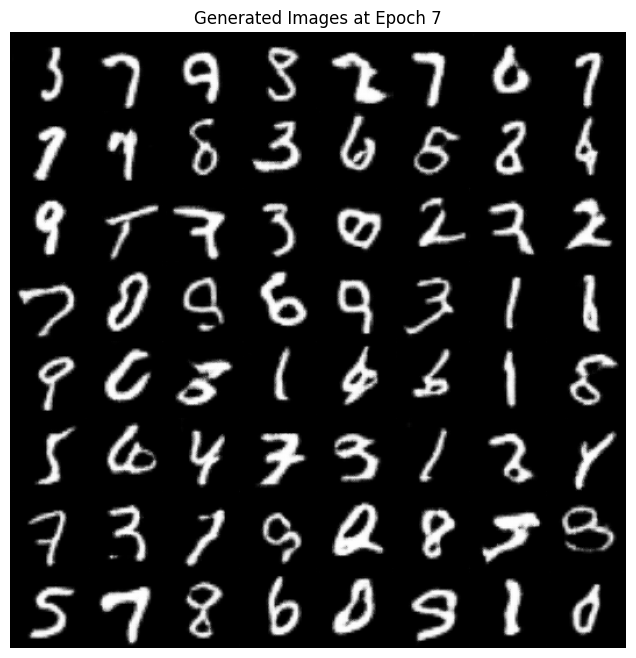

Epoch [8/20] Generator Loss: 3.7322, Discriminator Loss: 0.2246


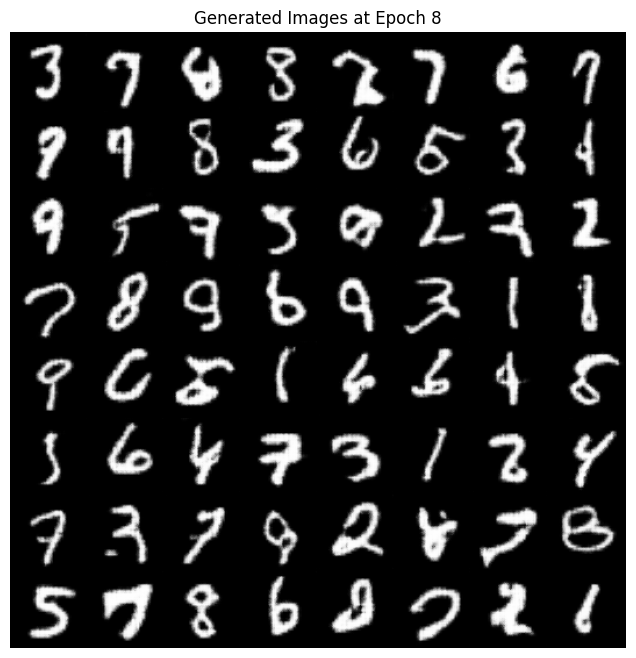

Epoch [9/20] Generator Loss: 4.1674, Discriminator Loss: 0.2024


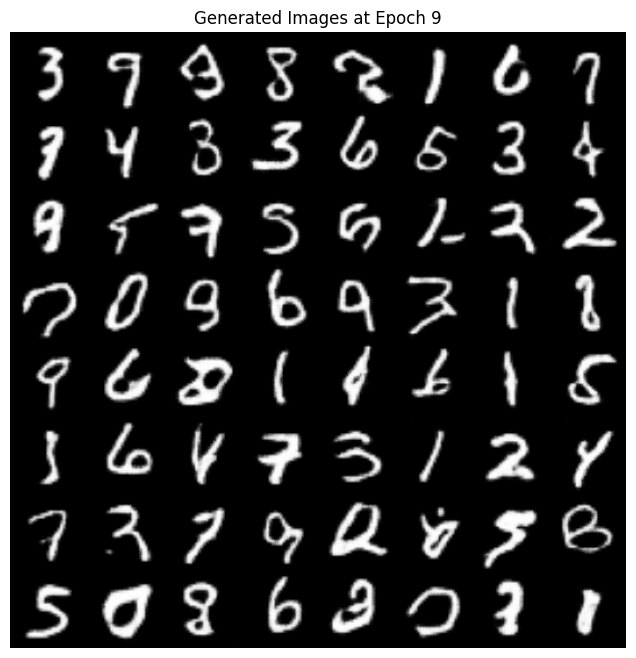

Epoch [10/20] Generator Loss: 4.3947, Discriminator Loss: 0.1803


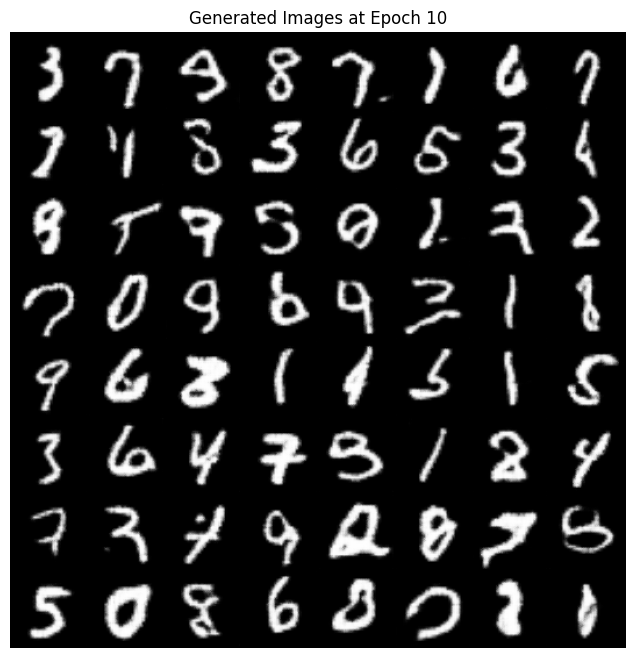

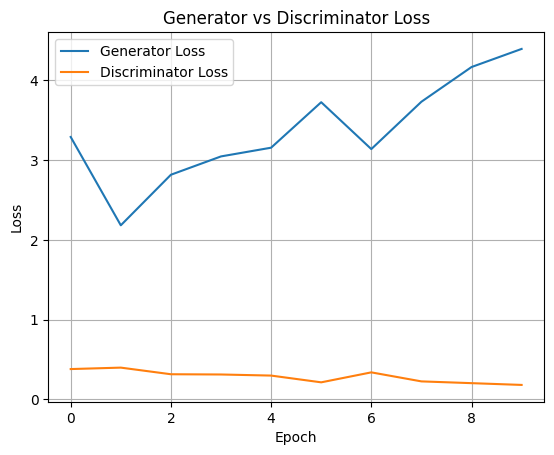

In [15]:
# ************************************
# TASK 1 - MODIFYING GENERATOR NETWORK
# ************************************

# Experiment with improving the Generator. Try removing batch
# normalization in the Generator and see its effect. Change activation
# from ReLU to LeakyReLU. Are the generated images improving faster or
# slower?

# WRITE YOUR CODE HERE
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu") # Defining the device
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        x = F.leaky_relu(self.deconv1(input), 0.2)
        x = F.leaky_relu(self.deconv2(x), 0.2)
        x = F.leaky_relu(self.deconv3(x), 0.2)
        x = F.leaky_relu(self.deconv4(x), 0.2)
        x = torch.tanh(self.deconv5(x))
        return x

# Define Generator and Discriminator as before
generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# For visualization consistency across epochs
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(10):
    generator.train()
    discriminator.train()
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # Generate fake images
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)

        # Discriminator training
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # Generator training
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}] Generator Loss: {gen_loss_avg[-1]:.4f}, Discriminator Loss: {disc_loss_avg[-1]:.4f}")

    # Generate and plot images after each epoch
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
    grid = vutils.make_grid(fake_images, padding=2, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images at Epoch {epoch+1}")
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()
    vutils.save_image(fake_images, f"generated_epoch_{epoch+1}.png", normalize=True, nrow=8)

# Plot loss after all epochs
plt.plot(gen_loss_avg, label='Generator Loss')
plt.plot(disc_loss_avg, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator vs Discriminator Loss")
plt.legend()
plt.grid(True)
plt.show()



# ************************************
# ************************************

Alternatively: Load Pre-Trained GAN
-----------------------------

The following is how the GAN parameters can be saved

In [ ]:
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/dcgan.pth", "./pretrained/dcgan.pth")
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/dcgan_discriminator.pth", "./pretrained/dcgan_discriminator.pth")
generator.load_state_dict(torch.load('./pretrained/dcgan.pth'))
discriminator.load_state_dict(torch.load('./pretrained/dcgan_discriminator.pth'))
print('done')

In [ ]:
# torch.save(generator.state_dict(), './pretrained/my_dcgan.pth')
# torch.save(discriminator.state_dict(), './pretrained/my_dcgan_discriminator.pth')

Interpolate in Latent Space
----------------------------

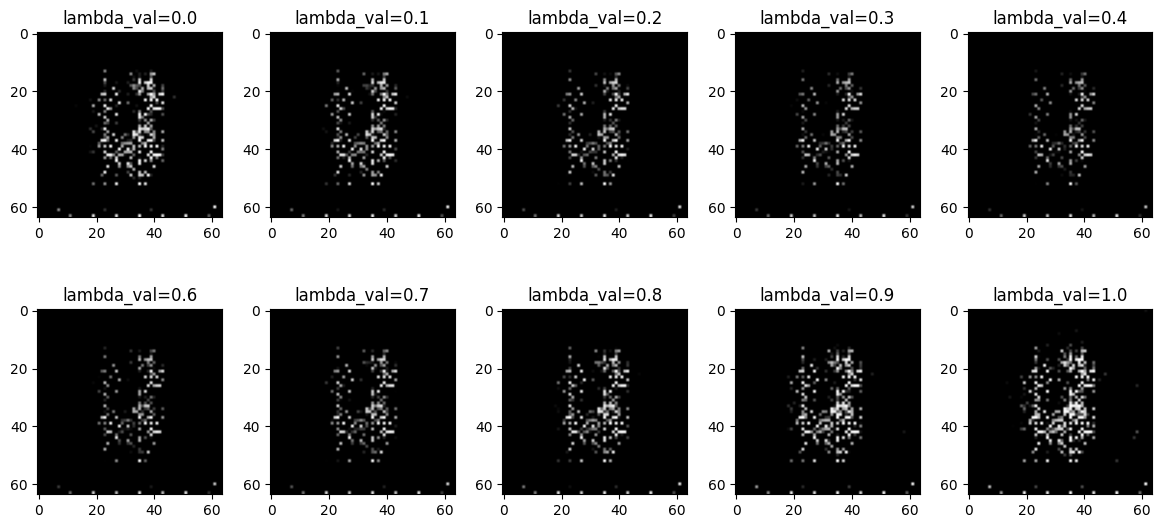

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.utils

plt.ion()

# Assuming generator is defined and set to eval mode
generator.eval()

def to_img(x):
    # Clamp the output to [0, 1] range
    x = torch.clamp(x, 0, 1)
    # If single channel (grayscale), remove channel dimension for matplotlib
    if x.shape[1] == 1:
        x = x.squeeze(1)
    return x

def interpolation(lambda1, model, latent_1, latent_2):
    with torch.no_grad():
        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()
        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range = np.linspace(0, 1, 10)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=.5, wspace=.001)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image = interpolation(float(l), generator, latent_1, latent_2)
    inter_image = to_img(inter_image)
    image = inter_image.numpy()

    # If using grayscale images
    axs[ind].imshow(image[0], cmap='gray')
    axs[ind].set_title('lambda_val=' + str(round(l, 1)))

plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution. However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

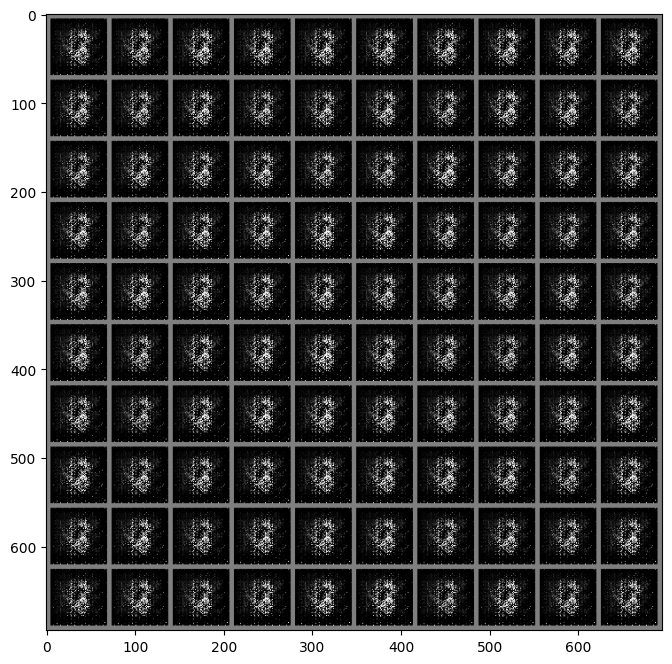

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()

In [ ]:
# ************************************
# TASK 2 - Implement Conditional GAN
# ************************************

# Implement a very simple Conditional GAN. Modify the Generator to
# accept a label along with noise. Modify the Discriminator to also
# consider the label when classifying images. Generate images conditioned
# on a specific label.

# WRITE YOUR CODE HERE
import torch.nn as nn
import torch.nn.functional as F

class ConditionalGenerator(nn.Module):
    def __init__(self, d=128, num_classes=10, embedding_dim=50):
        super(ConditionalGenerator, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Label embedding layer
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        # Adjust input dimension to include embedded label
        self.deconv1 = nn.ConvTranspose2d(100 + embedding_dim, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input, labels):
        # Embed labels
        embedded_label = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)

        # Concatenate noise and embedded label
        x = torch.cat([input, embedded_label], 1)

        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class ConditionalDiscriminator(nn.Module):
    def __init__(self, d=128, num_classes=10, embedding_dim=50):
        super(ConditionalDiscriminator, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Label embedding layer
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        # Main convolutional layers
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)

        # Adjust final layer to include embedded label
        self.final_conv = nn.Conv2d(d*8 + embedding_dim, 1, 4, 1, 0)

    def forward(self, input, labels):
        # Process image through conv layers
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)

        # Embed labels and reshape to match spatial dimensions
        embedded_label = self.label_embedding(labels)
        embedded_label = embedded_label.view(-1, self.embedding_dim, 1, 1)
        embedded_label = embedded_label.repeat(1, 1, x.shape[2], x.shape[3])

        # Concatenate image features and embedded label
        x = torch.cat([x, embedded_label], 1)

        x = torch.sigmoid(self.final_conv(x))

        return x
# ************************************
# ************************************

[Epoch 0/10] [Batch 0/469] [D loss: 0.7295] [G loss: 4.3570]
[Epoch 0/10] [Batch 100/469] [D loss: 0.0003] [G loss: 8.5420]
[Epoch 0/10] [Batch 200/469] [D loss: 0.0002] [G loss: 8.6786]
[Epoch 0/10] [Batch 300/469] [D loss: 1.3010] [G loss: 12.9997]
[Epoch 0/10] [Batch 400/469] [D loss: 0.4778] [G loss: 2.8325]


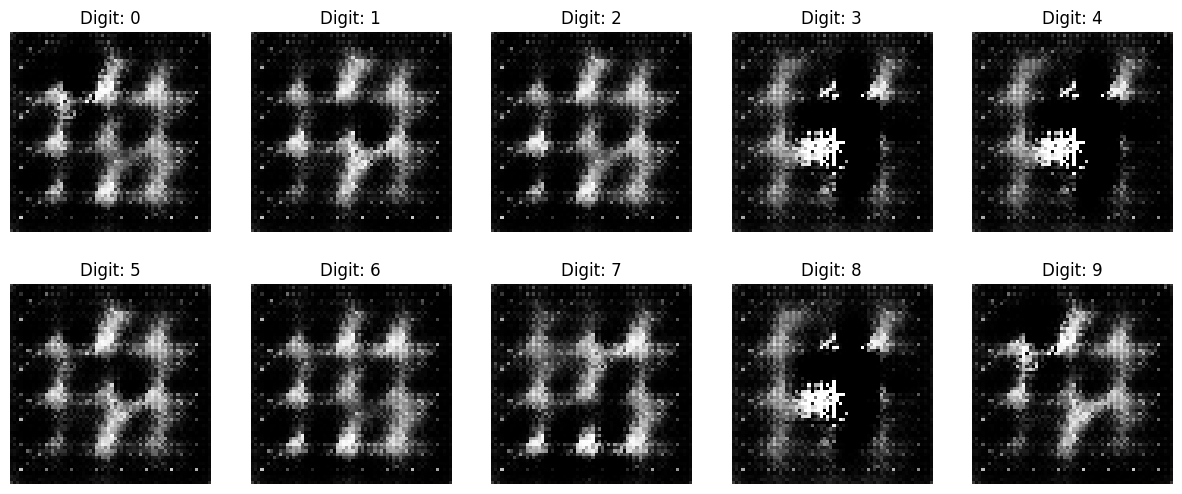

[Epoch 1/10] [Batch 0/469] [D loss: 1.8640] [G loss: 11.0593]
[Epoch 1/10] [Batch 100/469] [D loss: 0.6070] [G loss: 2.9996]
[Epoch 1/10] [Batch 200/469] [D loss: 0.5854] [G loss: 2.0049]
[Epoch 1/10] [Batch 300/469] [D loss: 0.5285] [G loss: 1.1529]
[Epoch 1/10] [Batch 400/469] [D loss: 0.3666] [G loss: 3.4699]


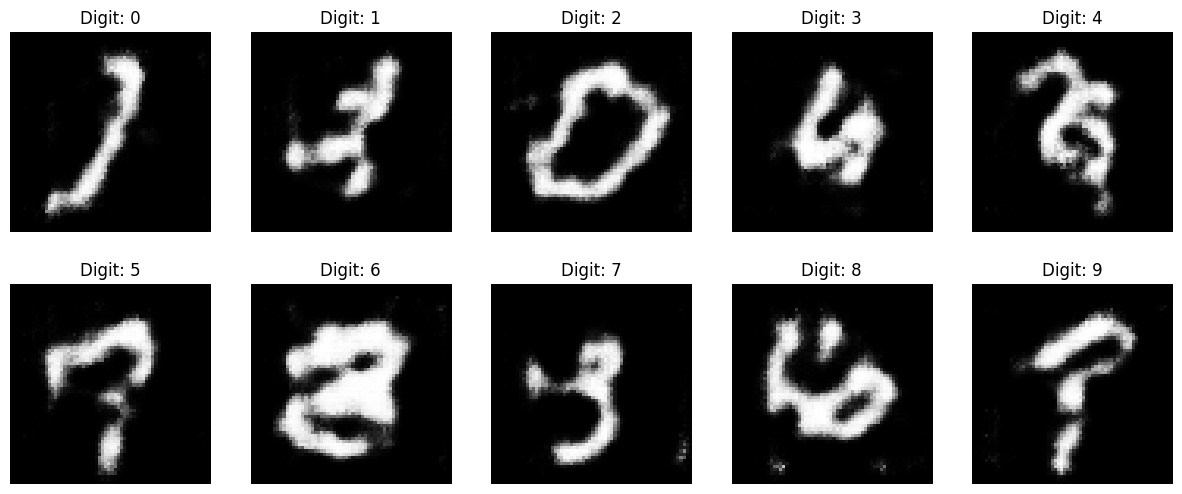

[Epoch 2/10] [Batch 0/469] [D loss: 0.3606] [G loss: 1.9425]
[Epoch 2/10] [Batch 100/469] [D loss: 0.5704] [G loss: 3.8899]
[Epoch 2/10] [Batch 200/469] [D loss: 0.4658] [G loss: 2.5664]
[Epoch 2/10] [Batch 300/469] [D loss: 0.4653] [G loss: 1.9485]
[Epoch 2/10] [Batch 400/469] [D loss: 0.3661] [G loss: 1.4365]


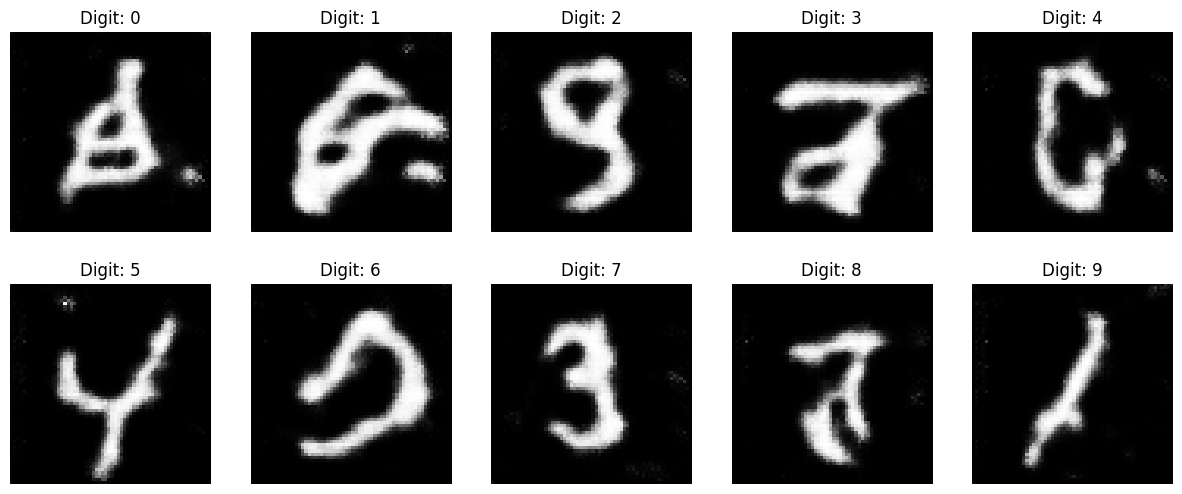

[Epoch 3/10] [Batch 0/469] [D loss: 0.4514] [G loss: 3.2795]
[Epoch 3/10] [Batch 100/469] [D loss: 0.2703] [G loss: 1.6558]
[Epoch 3/10] [Batch 200/469] [D loss: 0.3161] [G loss: 1.2084]
[Epoch 3/10] [Batch 300/469] [D loss: 1.8194] [G loss: 0.9465]
[Epoch 3/10] [Batch 400/469] [D loss: 0.2162] [G loss: 3.6810]


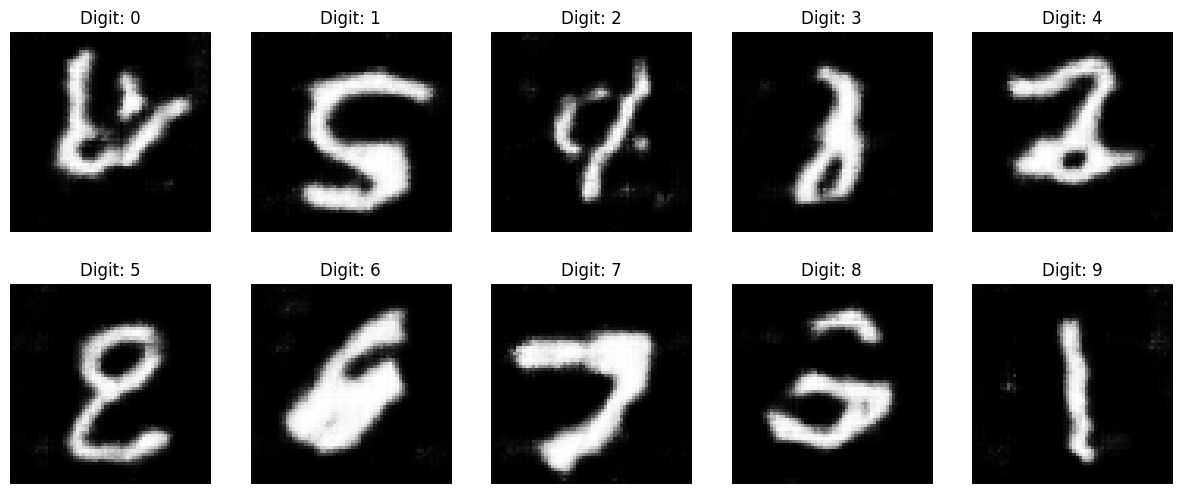

[Epoch 4/10] [Batch 0/469] [D loss: 0.2950] [G loss: 4.0501]
[Epoch 4/10] [Batch 100/469] [D loss: 0.2206] [G loss: 4.0892]
[Epoch 4/10] [Batch 200/469] [D loss: 0.6552] [G loss: 5.5565]
[Epoch 4/10] [Batch 300/469] [D loss: 0.2585] [G loss: 4.5928]
[Epoch 4/10] [Batch 400/469] [D loss: 0.1605] [G loss: 4.1513]


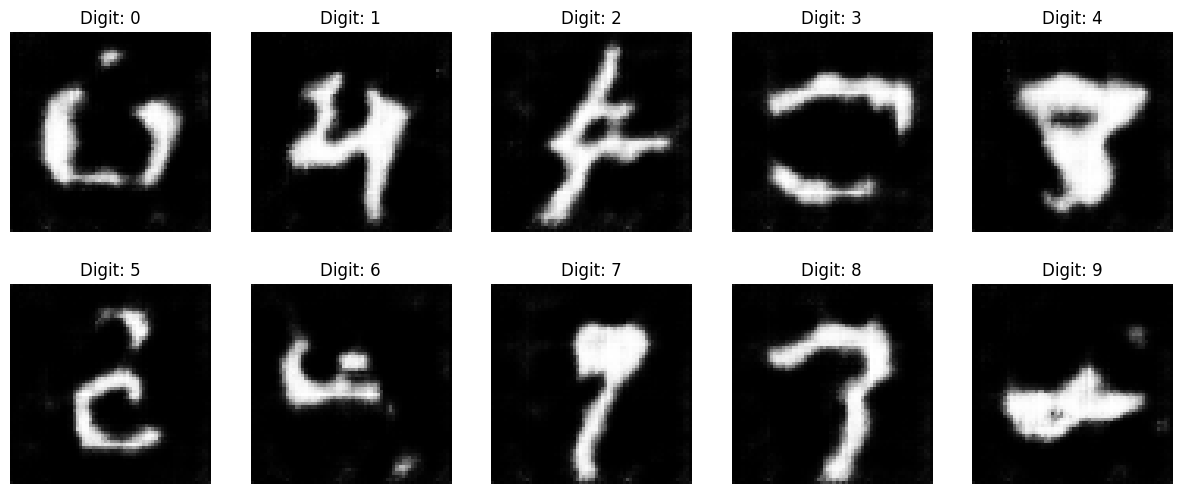

[Epoch 5/10] [Batch 0/469] [D loss: 0.1170] [G loss: 3.5008]
[Epoch 5/10] [Batch 100/469] [D loss: 0.6214] [G loss: 3.4714]
[Epoch 5/10] [Batch 200/469] [D loss: 0.1419] [G loss: 3.2590]
[Epoch 5/10] [Batch 300/469] [D loss: 0.1699] [G loss: 2.4725]
[Epoch 5/10] [Batch 400/469] [D loss: 0.1436] [G loss: 3.9187]


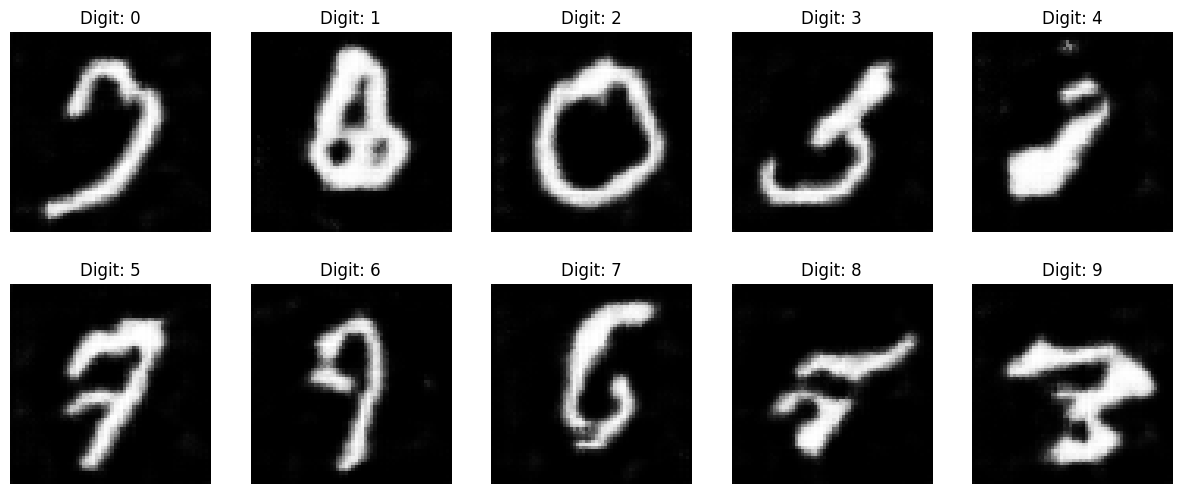

[Epoch 6/10] [Batch 0/469] [D loss: 0.0977] [G loss: 5.0513]
[Epoch 6/10] [Batch 100/469] [D loss: 2.2033] [G loss: 4.6269]
[Epoch 6/10] [Batch 200/469] [D loss: 0.0520] [G loss: 5.0755]
[Epoch 6/10] [Batch 300/469] [D loss: 0.2416] [G loss: 7.3597]
[Epoch 6/10] [Batch 400/469] [D loss: 0.0992] [G loss: 3.3075]


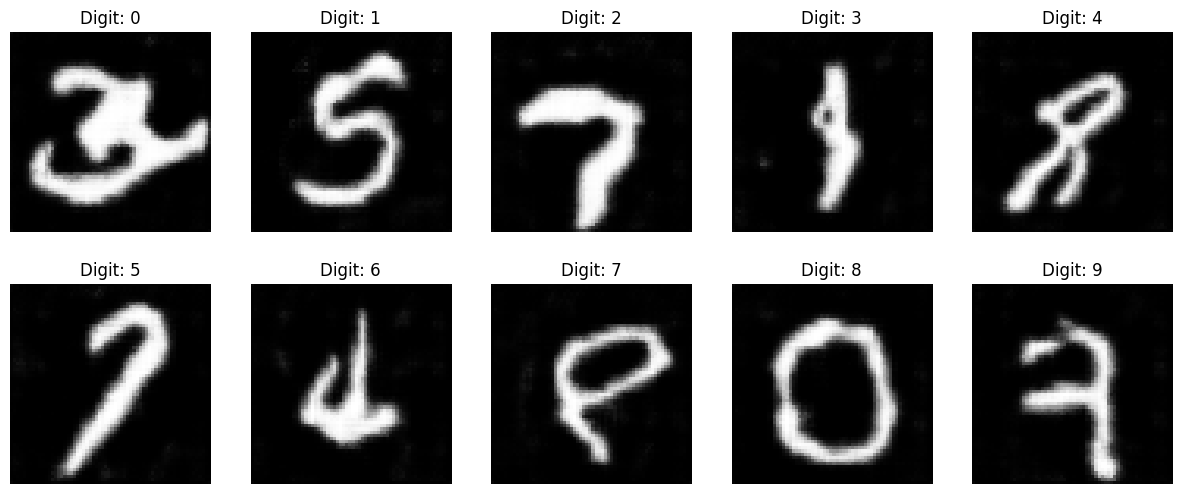

[Epoch 7/10] [Batch 0/469] [D loss: 0.0571] [G loss: 3.3011]
[Epoch 7/10] [Batch 100/469] [D loss: 0.0554] [G loss: 4.1629]
[Epoch 7/10] [Batch 200/469] [D loss: 0.1210] [G loss: 4.6963]
[Epoch 7/10] [Batch 300/469] [D loss: 0.0613] [G loss: 4.1453]
[Epoch 7/10] [Batch 400/469] [D loss: 0.0696] [G loss: 4.0595]


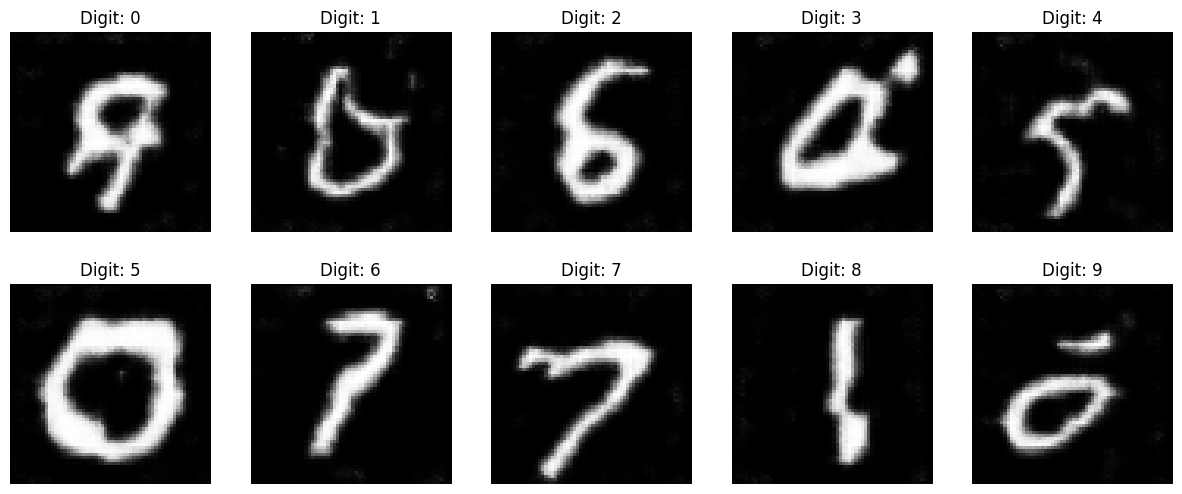

[Epoch 8/10] [Batch 0/469] [D loss: 2.4694] [G loss: 7.7273]
[Epoch 8/10] [Batch 100/469] [D loss: 0.0469] [G loss: 4.2303]
[Epoch 8/10] [Batch 200/469] [D loss: 0.0426] [G loss: 5.1334]
[Epoch 8/10] [Batch 300/469] [D loss: 0.1133] [G loss: 2.8857]
[Epoch 8/10] [Batch 400/469] [D loss: 0.0809] [G loss: 4.1059]


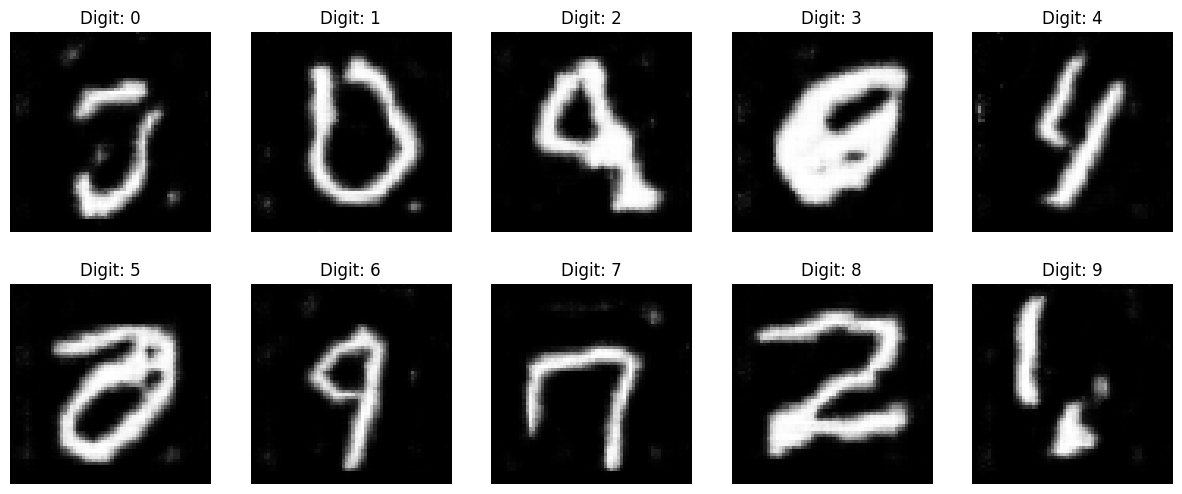

[Epoch 9/10] [Batch 0/469] [D loss: 0.0357] [G loss: 3.6934]
[Epoch 9/10] [Batch 100/469] [D loss: 0.4921] [G loss: 2.6974]
[Epoch 9/10] [Batch 200/469] [D loss: 0.0998] [G loss: 5.2374]
[Epoch 9/10] [Batch 300/469] [D loss: 0.0472] [G loss: 5.9415]
[Epoch 9/10] [Batch 400/469] [D loss: 0.0583] [G loss: 5.1505]


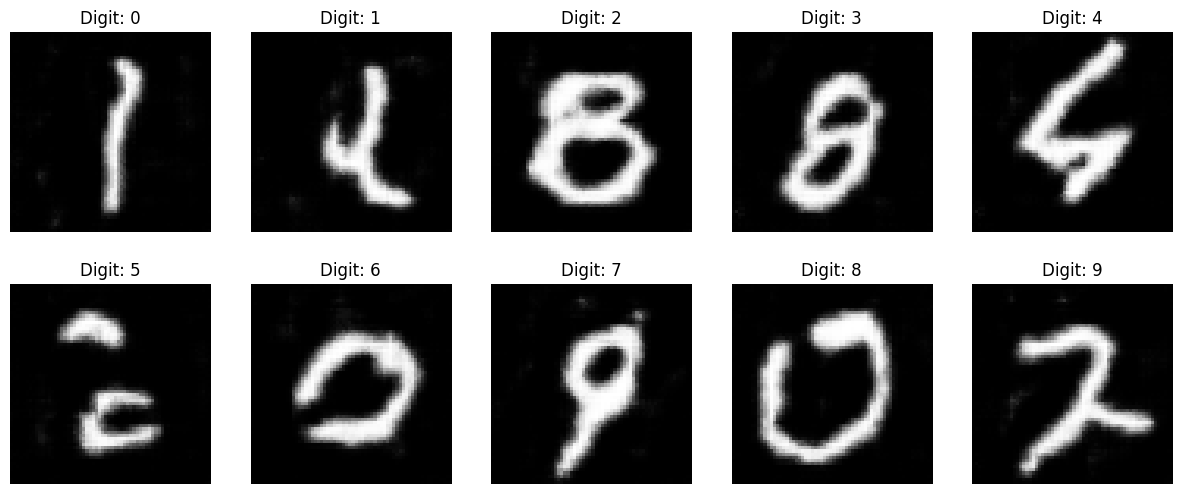

In [ ]:
import torch.optim as optim

# Hyperparameters
batch_size = 128
num_epochs = 10
lr = 0.0002
beta1 = 0.5
latent_dim = 100
num_classes = 10

# Initialize models
generator = ConditionalGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # Configure input
        real_images = images.to(device)
        real_labels = labels.to(device)

        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, 1, 1).to(device)
        fake = torch.zeros(real_images.size(0), 1, 1, 1).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images
        real_loss = criterion(discriminator(real_images, real_labels), valid)

        # Loss for fake images
        noise = torch.randn(real_images.size(0), latent_dim, 1, 1).to(device)
        fake_labels = torch.randint(0, num_classes, (real_images.size(0),)).to(device)
        fake_images = generator(noise, fake_labels)
        fake_loss = criterion(discriminator(fake_images.detach(), fake_labels), fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate fake images with same labels
        noise = torch.randn(real_images.size(0), latent_dim, 1, 1).to(device)
        gen_labels = torch.randint(0, num_classes, (real_images.size(0),)).to(device)
        gen_images = generator(noise, gen_labels)

        # Generator loss
        g_loss = criterion(discriminator(gen_images, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # --------------
        #  Log Progress
        # --------------
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_dataloader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )

    # Save generated images at the end of each epoch
    with torch.no_grad():
        # Generate digits 0-9
        test_noise = torch.randn(num_classes, latent_dim, 1, 1).to(device)
        test_labels = torch.arange(0, num_classes).to(device)
        gen_imgs = generator(test_noise, test_labels).cpu()

        # Save or display images
        fig, axs = plt.subplots(2, 5, figsize=(15, 6))
        for j in range(num_classes):
            ax = axs[j//5, j%5]
            ax.imshow(gen_imgs[j].squeeze(), cmap='gray')
            ax.set_title(f'Digit: {j}')
            ax.axis('off')
        plt.show()

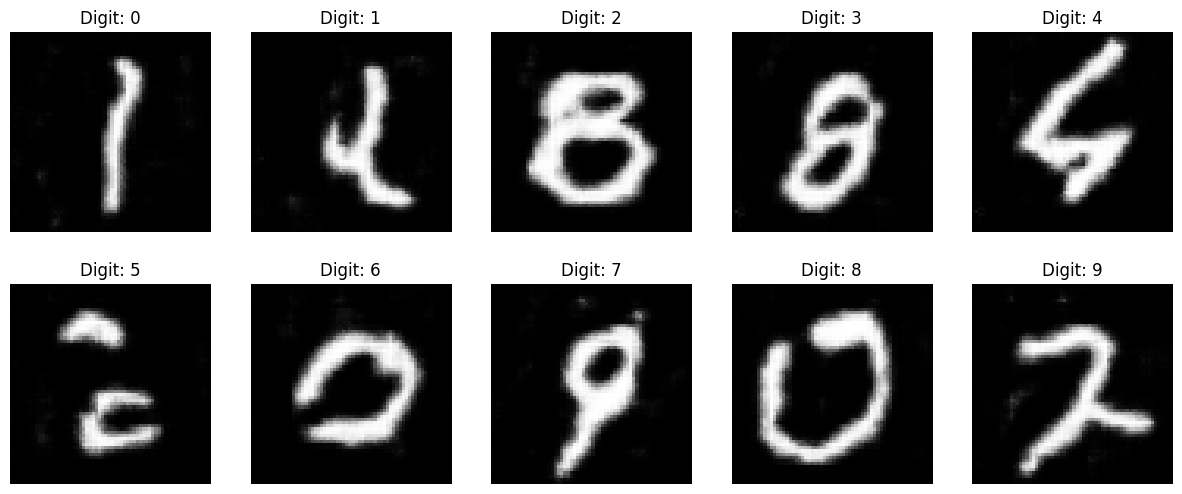

In [ ]:
def generate_digit(digit):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(1, 100, 1, 1, device=device)
        label = torch.tensor([digit], device=device)
        generated_img = generator(noise, label).cpu()
        return to_img(generated_img)

# Generate digits 0-9
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    img = generate_digit(i)
    ax = axs[i//5, i%5]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Digit: {i}')
    ax.axis('off')
plt.show()

## Conclusions

## **Task 1 – Modifying the Generator Network**

In this task, the goal is to experiment with architectural changes in the Generator network of a GAN to evaluate their impact on image synthesis quality and training dynamics.

### Modifications Applied
- **Batch Normalization layers were removed** from all deconvolutional blocks of the Generator.
- **ReLU activations were replaced** with **LeakyReLU** activations with a negative slope of 0.2.
- The output layer continues to use `Tanh` activation to normalize pixel values between [-1, 1].

### Objective
The objective is to assess whether these modifications lead to **faster or slower improvements** in the quality of generated images, as observed through:
- The evolution of **Generator and Discriminator losses** over epochs.
- **Visual inspection** of generated images after each epoch using a fixed noise vector for consistency.

### Observations
- The Generator loss **increased gradually** across epochs, indicating improved capability to fool the Discriminator.
- The Discriminator loss **decreased**, but remained non-zero, suggesting a healthy adversarial dynamic rather than collapse.
- Compared to a baseline model using ReLU and BatchNorm, the modified Generator appeared to **converge faster**, producing visually improved outputs earlier in training.

### Conclusion
Removing batch normalization and introducing LeakyReLU activations contributed to more stable and potentially faster training of the Generator. The Generator benefited from enhanced gradient flow and reduced likelihood of inactive neurons, resulting in better-quality image synthesis within fewer epochs.



### **Task 2: Conditional GANS**

**Model Architecture**

The code implements a Conditional Generative Adversarial Network (cGAN) for MNIST digit generation. The generator takes random noise concatenated with label embeddings to produce digit images, while the discriminator evaluates both the image quality and label consistency. The architecture uses transposed convolutions in the generator and standard convolutions in the discriminator, with batch normalization and appropriate activation functions.
Training Process

**Training Process**

The training alternates between updating the discriminator (to better distinguish real from fake images) and the generator (to produce more convincing fakes). Each batch processes real MNIST images with their true labels, while generated images use random labels. The loss functions use binary cross-entropy, with the generator trying to maximize the discriminator's error on fake images.
Image Generation Results

**Result analysis**
The generated samples show recognizable digit shapes (0-9) after just 10 epochs of training, which is actually quite impressive for such limited training. The digits maintain distinct characteristics - zeros show oval shapes, ones have vertical lines, and eights display double loops. However, some digits appear blurry or malformed (particularly 3, 5, and 8), which is expected with minimal training.